In [1]:
import torch 
from scripts.sample_diffusion import *
import argparse, os, sys, glob, datetime, yaml
from omegaconf import OmegaConf
import torchvision
import PIL
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from ldm_testing import *
from jscc_baseline_testing import deep_jscc_testing

In [2]:
!nvidia-smi

Sun Jul 16 17:19:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:1E:00.0 Off |                    0 |
|  0%   34C    P0               54W / 300W|      0MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
test_snr_dB = 10
test_snr_ratio = 10**(test_snr_dB/10)

In [4]:
config = OmegaConf.load("configs/latent-diffusion/lsun_bedrooms_posterior.yaml")
config.model.params.channel_snr_dB = test_snr_dB
ldm_posterior_model = instantiate_from_config(config["model"])
ldm_posterior_model = ldm_posterior_model.to("cuda")

LatentDiffusionPosteriorJSCC: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from models/ldm/lsun_beds256/autoencoder.ckpt...
Total Params: 55298206
Total Trainable Params: 55298206
Training LatentDiffusionPosteriorJSCC as an unconditional model.


In [5]:
root_dir = "/tmpssd/ashri/LSUN/"
val_txt_path = os.path.join(root_dir, "bedrooms_val.txt")
val_data_dir = os.path.join(root_dir, "bedrooms")
config.data.params.validation.params.txt_file = val_txt_path
config.data.params.validation.params.data_root = val_data_dir

In [6]:
dataset = instantiate_from_config(config.data.params.validation)
data_dict = dataset[0]
image = data_dict['image']

In [7]:
def normalize(x:torch.tensor):
    return (x - x.min())/(x.max() - x.min())

In [8]:
scale_function = lambda img: (2*img - 1.0)
ScaleShiftTransform = torchvision.transforms.Lambda(scale_function)
data_transform = ToTensor()

In [9]:
tensor_image = data_transform(image).cuda()[None]
tensor_image.shape

torch.Size([1, 3, 256, 256])

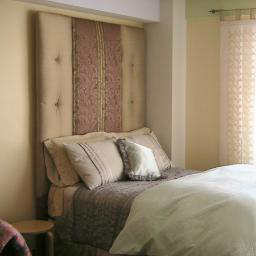

In [10]:
input_image = custom_to_pil(tensor_image[0])
input_image

In [11]:
input_image.save("input.png")

In [12]:
codeword = ldm_posterior_model.first_stage_model.encode(tensor_image)
noisy_codeword = torch.sqrt(torch.tensor(test_snr_ratio))*codeword + torch.randn_like(codeword)

In [13]:
sampled_codeword = ldm_posterior_model.langevin_sampling(test_snr_dB, noisy_codeword, 1e-3, True, sampling_mode="posterior")

Progressive Generation: 100%|██████████| 54/54 [00:26<00:00,  2.08it/s]


In [14]:
recon = ldm_posterior_model.first_stage_model.decode(sampled_codeword)

In [15]:
recon_image = to_pil_image(normalize(recon[0]))

In [16]:
recon_image.save("recon.png")

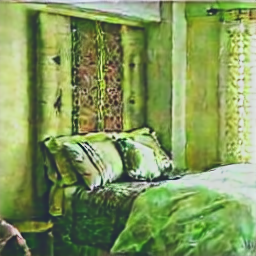

In [17]:
recon_image

In [18]:
torch.std(recon)

tensor(0.7806, device='cuda:0', grad_fn=<StdBackward0>)